## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [7]:
import glob

import numpy as np
import scipy as sp
import scipy.signal
import scipy.io


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def BandpassFilter(signal, fs):
    """
    Filters out low and high frequencies
    
    Args:
        signal: a numpy array of the signal
        fs: the sampling frequency in Hz
        
    Returns:
        A filtered signal
    """
    low_freq, high_freq = 40 / 60, 240 / 60 # divide by seconds in a minute to get Hz
    b, a = scipy.signal.butter(3, (low_freq, high_freq), btype='bandpass', fs=fs)
    return scipy.signal.filtfilt(b, a, signal)

def FFT(signal, fs):
    fft = np.abs(np.fft.rfft(signal))
    fftfreq = np.fft.rfftfreq(len(signal), 1 / fs)
    return fft, fftfreq

def Confidence(bpm_estimate_freq, fft, fftfreqs, frequency_neighbourhood=30/60):
    """
    Calculates the confidence using the energy spectrum of the neighbourhood around the estimated frequency
    
    Args:
        bpm_estimate_freq: the estimated frequency of the heart rate
        fft: the fourier transform of the PPG signal
        fftfreqs: the corresponding frequencies of the PPG signal
    """
    
    # frequency_neighbourhood up and down from the bpm_estimate_freq
    bpm_neighbourhood_mask = (fftfreqs > bpm_estimate_freq - frequency_neighbourhood) & (fftfreqs < bpm_estimate_freq + frequency_neighbourhood)
    window_energy = np.sum(fft[bpm_neighbourhood_mask])
    return window_energy / np.sum(fft)
    
def ComputeHeartRate(ppg, acc, fs):
    
    '''
        From the data docs:
        BPM value is in every 8-second time window. Two successive time windows overlap by 6 seconds.
        Thus the first value in 'BPM0' gives the calculated heart rate ground-truth in
        the first 8 seconds, while the second value in 'BPM0' gives the calculated heart rate ground-truth
        from the 3rd second to the 10th second
        
        Thus, we will estimate the ppg signal using the same window size.
        
        Args:
            ppg: filtered PPG data
            acc: an array containing the 3 components of the accelerometer 
            fs: sampling frequency
        
        Returns:
            hr_estimates: an array of the chosen heart rate estimates. each value represents the heart rate in an 8 second window
            hr_confidences: an array of the confidences as calculated using Confidence() 
    '''
    
    interval_jump = 2 * fs # samples/second number of values into the data
    window_size = 8 * fs
    diff_threshold = 0.2
    hr_diff_threshold = 0.15
    previous_hr_window_size = 5
    
    hr_estimates, hr_confidences = [], []
    
    accx, accy, accz = acc[0], acc[1], acc[2]
    
    ''' 
        Loop through the entire signal in steps, find the primary frequencies of the strongest ppg and acc signal 
        (these indicate heart beat and movement, respectively).
        if they're nearly the same, pick the next best ppg signal. 
        If there's no best next signal, assume the ppg sensor and accelerometer truly synced up.
        Also calculate the energy of the frequency spectrum in the neighbourhood
        of the pulse estimate for the confidence estimate
        
        Assumption: heart rate is relatively constant within 8 second windows during steady state activity
        so should have a detectable frequency.
    '''
    
    for i in range(0, len(ppg) - window_size, interval_jump):
        ppg_fourier, ppg_freqs = FFT(ppg[i:i + window_size], fs)
        accx_fourier, accx_freqs = FFT(accx[i:i + window_size], fs)
        accy_fourier, accy_freqs = FFT(accy[i:i + window_size], fs)
        accz_fourier, accz_freqs = FFT(accz[i:i + window_size], fs)
    
        # get the indices that sort the frequency components
        bpm_candidate_indices = np.argsort(ppg_fourier)
        accx_candidate_indices = np.argsort(accx_fourier)
        accy_candidate_indices = np.argsort(accy_fourier)
        accz_candidate_indices = np.argsort(accz_fourier)
        
        # choose the highest frequencies for each signal
        ppg_dominant_f = ppg_freqs[bpm_candidate_indices[-1]]
        accx_dominant_f = accx_freqs[accx_candidate_indices[-1]]
        accy_dominant_f = accy_freqs[accy_candidate_indices[-1]]
        accz_dominant_f = accz_freqs[accz_candidate_indices[-1]]
        
        
        # select the best frequency for the heart rate estimate if the PPG and accelerometer frequencies are similar
        close_match = np.abs(ppg_dominant_f - accx_dominant_f) < diff_threshold or\
        np.abs(ppg_dominant_f - accy_dominant_f) < diff_threshold or\
        np.abs(ppg_dominant_f - accz_dominant_f) < diff_threshold
        
        if close_match and len(hr_estimates) >= previous_hr_window_size:
            k = 2
            
            next_candidate = ppg_freqs[bpm_candidate_indices[-k]]
            
            previous_hr_window_mean = np.mean(hr_estimates[-previous_hr_window_size:]) 
            # if the first next_candidate is within 15% of the mean of the last 5 measurement, skip loop
            # otherwise, try finding a next candidate (in at most k steps)
            while k <= 5 and\
                np.abs(previous_hr_window_mean - next_candidate * 60) / previous_hr_window_mean > hr_diff_threshold:
                k += 1
                next_candidate = ppg_freqs[bpm_candidate_indices[-k]]

            ppg_dominant_f = next_candidate
        hr_estimates.append(ppg_dominant_f * 60)
        hr_confidences.append(Confidence(ppg_dominant_f, ppg_fourier, ppg_freqs))
        
    return hr_estimates, hr_confidences

def RunPulseRateAlgorithm(data_fl, ref_fl):
    fs = 125 # sampling frequency for the data, Hz

    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    # Filter the signals to within 40 and 240 bpm
    ppg = BandpassFilter(ppg, fs)
    accx = BandpassFilter(accx, fs)
    accy = BandpassFilter(accy, fs)
    accz = BandpassFilter(accz, fs)
        
    # Compute pulse rate estimates and estimation confidence.
    hr_estimates, hr_confidences = ComputeHeartRate(ppg, [accx, accy, accz], fs)
    
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    reference_hr = sp.io.loadmat(ref_fl)['BPM0']
    
    errors = np.diag(np.subtract(hr_estimates, reference_hr))
    
    return errors, hr_confidences

Evaluate()

8.322564029416503

#### Data exploration

In [8]:
from matplotlib import pyplot as plt

In [9]:
%matplotlib inline

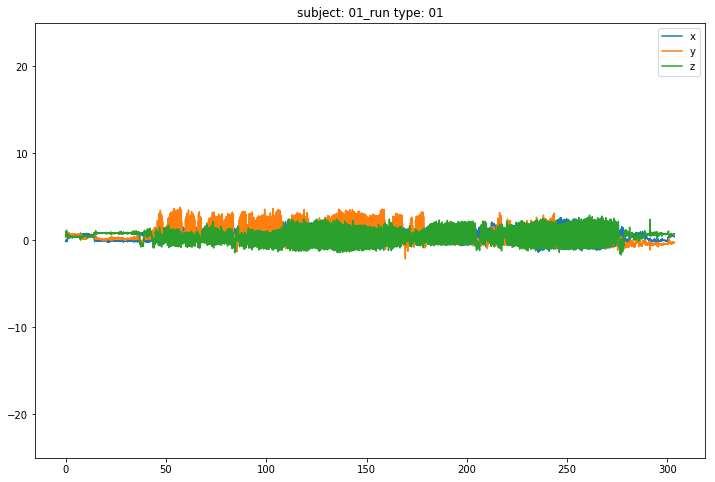

In [10]:
fs = 125
data_fls, ref_fls = LoadTroikaDataset()

_, subject_id, run_type = data_fls[0].split('/')[-1].split('_')
run_type = run_type[4:6]
    
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

ts = np.arange(len(ppg)) / fs
plt.figure(figsize=(12, 8))  
plt.plot(ts, accx, label='x')
plt.plot(ts, accy, label='y')
plt.plot(ts, accz, label='z')
plt.title('{}_{}'.format("subject: " + subject_id, "run type: " + run_type))
plt.legend()
plt.ylim((-25, 25))
plt.draw()

In [26]:
def plot_freqdomain(data, title, fs):    
    bandpass = BandpassFilter(data, fs)
    fft, freqs = FFT(bandpass, fs)
    plt.clf()
    plt.title(title)
    plt.plot(freqs, np.abs(fft))
    plt.xlabel('Frequency (Hz)')

In [12]:
len(ppg)/fs # samples / (samples/s) = seconds

303.496

In [13]:
window_len = 8*fs

The amplitude of the waves in the first graph is larger at the beginning and end and this corresponds to movement in the accelerometer as seen in the second graph.

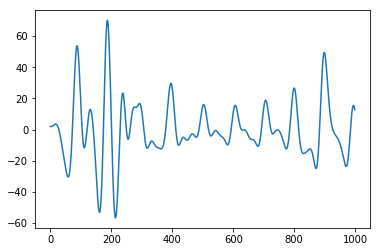

In [14]:
plt.plot(BandpassFilter(ppg[:window_len], fs))

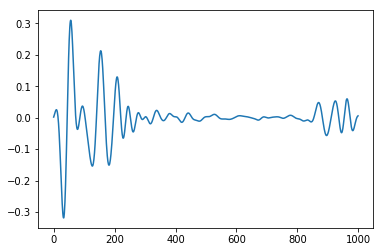

In [15]:
acc = np.sqrt(accx**2 + accy**2 + accz**2)
plt.plot(BandpassFilter(acc[:window_len], fs))

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - ComputeHeartRate(ppg, acc, fs) takes in the bandpass filtered PPG signal, an array of the 3 components of the accelerometer, and the data sampling frequency and returns the heart rate estimates for the data. Run Evaluate() to get the mean error.

> - **Data Description** - The data consists of two-channel PPG signals, three-axis acceleration signals, and one-channel ECG signals that were simultaneously recorded from subjects with age from 18 to 35. The ECG signals were used to create target ground-truth values for heart rate (as ECGs are more accurate than wrist-based PPG). The subjects were told to run complete two heart rate tests. There are only 12 subjects and no demographic data in this study.

> - **Algorithhm Description** - Since the ground-truth values are given for each 8 second window with a stride of 2 seconds, the algorithm takes each 8 second window for the PPG and separate accelerometer components, performs a bandpass filter to remove low and high frequencies (noise) and then computes the fourier transform of each component window to attempt to separate the motion induced frequencies from the PPG signal. The highest frequency for the PPG is chosen and compared to each component of the accelerometer. If any is within 0.2, then the next good candidate for the PPG is chosen (the next candidate is chosen at most 4 times). The criteria is that the next candidate heart rate is within 15% of the mean of the previous 7 heart rate estimates. This is because heart rate does not vary drastically during steady state activities. 15% is therefore large enough to account for shifts in heart rate between running at 8 km/h and 15 km/h, for example, but small enough to discard unusual frequencies. The algorithm returns the heart rate estimates as well as the confidences for each estimate. These confidences are measured as the ratio of the sum of the frequencies surrounding the chose estimate frequency to the sum of the entire spectrum. The window size around which to sum the frequencies was determined so as to produce a good BPM estimate.

> - **Algorithm Performance** - The mean absolute error for the best 90% of estimates was used as a performance metric. On the training set, the algorithm achieves an error of 8.32 beats and on the test set it has an error of 2.48, well below the allowable maximum of 15 beats. The algorithm is tuned for heart rate below 210bpm. While this is reasonable for most individuals exercising at the prescribed pace, it may not be accurate for young people who physiologically have higher heart rates than the adults in the data. However, the algorithm works quite well for the given data and could be a useful starting point in building a more general algorithm with a larger, more diverse dataset that has more age groups and activity types.

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 